In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
#from skopt.space import Real, Categorical, Integer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Import Data

In [6]:
data = '../data/iir_feat_tensor_full_with_full_labels.mat'
savePath = '../results/MLResults/IIR/'
#data = pd.read_csv(data, header=None)
#data.head()
#X = data.iloc[1:,0:-2]
#y = data.iloc[1:,-1]

matContent = sio.loadmat(data)
X = matContent['nc_feat']
y = np.squeeze(matContent['nc_multi_labels'])

experiment = 'MultiClass_IIR_NC'

filename = savePath+'ML_'+experiment+'.mat'

cm_title = 'Categorical Emotion Classification for IIR features - NC (NB)'

X = np.reshape(X, (X.shape[0],X.shape[1]*X.shape[2]))
del matContent

print(X.shape)

(6599, 8960)


In [7]:
def reduce_dim(X, y, pca_thresh, Scaler):
    y=y
    #y = np.ravel(y)
    if Scaler=="MinMax":
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler()
        X = sc.fit_transform(X)
    elif Scaler=="MaxAbs":
        from sklearn.preprocessing import MaxAbsScaler
        sc = MaxAbsScaler()
        X = sc.fit_transform(X)
    elif Scaler == "Standard":
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X = sc.fit_transform(X)
    elif Scaler == "Normalizer":
        from sklearn.preprocessing import Normalizer
        sc = Normalizer()
        X = sc.fit_transform(X)
    else:
        pass

    pca = PCA(pca_thresh)
    X = pca.fit_transform(X)
    return X, y

In [8]:
X, y = reduce_dim(X, y, 0.95, 'Normalizer')
print(X.shape)

(6599, 3128)


# KNN Classifier

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 13.5min finished


Best parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Accuracy: 0.201 +- 0.013
Weighted FScore: 0.201 +- 0.013
Macro FScore: 0.201 +- 0.013


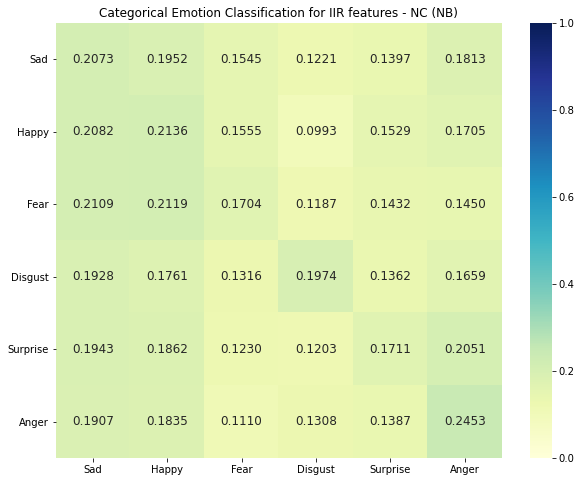

In [9]:
#KNeighbors

#scoring = {'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score, average='weighted')}
depth = np.logspace(0.001,10)
param = {'n_neighbors':[2,3,4,5,6,7,8,9,10], 'weights':['uniform','distance'],
         'metric':['euclidean','chebychev','minkowski']}

opt = GridSearchCV(KNeighborsClassifier(), param_grid=param, cv=10, verbose=2, n_jobs=-1)
clf = opt.fit(X,y)
best_params = opt.best_params_
print('Best parameters:', best_params)

kfold = StratifiedKFold(n_splits=10, shuffle=True)
acc_list = [] 
f1_list = []

estimator = KNeighborsClassifier(n_neighbors=best_params.get('n_neighbors'), weights=best_params.get('weights'), 
                                metric=best_params.get('metric'))
   
'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring=scoring, verbose=2)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print('Accuracy:', round(np.mean(acc),4), '+-', round(np.std(acc),4)) 
print('F1Score:', round(np.mean(f1),4), '+-', round(np.std(f1),4))
'''
cm_list = []
acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
#conf_mat = np.zeros((2,2))
conf_mat = np.zeros((6,6))
for train_index, test_index in kfold.split(X, y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 
    estimator.fit(X_train, y_train) 
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    wtd_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_f1 = f1_score(y_test, y_pred, average='micro')
    wtd_f1_list.append(wtd_f1)
    macro_f1_list.append(macro_f1)
    #cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5,6])
    cm = cm/cm.sum(axis=1, keepdims=True)
    #conf_mat = conf_mat+cm
    cm_list.append(cm)

#conf_mat /= conf_mat.sum(axis=1, keepdims=True) #Normalised values in the CM
conf_mat = np.mean(cm_list, axis=0)
acc_mean = round(np.mean(acc_list),3)
acc_std = round(np.std(acc_list),3)
wtd_f1_mean = round(np.mean(wtd_f1_list),3)
wtd_f1_std = round(np.std(wtd_f1_list),3)
macro_f1_mean = round(np.mean(macro_f1_list),3)
macro_f1_std = round(np.std(macro_f1_list),3)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
#ax.set_yticklabels(['LA','HA'],rotation = 0)
#ax.set_xticklabels(['LA','HA'],rotation = 0)
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'],rotation = 0)
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

# Save results
sio.savemat(filename, {'experiment':experiment, 'conf_mat':conf_mat, 'conf_mat_list': cm_list,
                       'best_params':best_params, 'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 
                       'macro_f1_list':macro_f1_list})

# SVM Classifier

In [ ]:
#Poly SVM

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score, average='weighted')}
#scoring = ['accuracy', 'f1_score']
'''
param = {'C':Real(1e-3,1e+3,prior='log-uniform'),
         'gamma':Real(1e-3,1e+1,prior='log-uniform')}
'''
param = {'C':[0.001,0.01,0.1,1,10,100,1000]}

opt = GridSearchCV(SVC(), param_grid=param, cv=10, verbose=2, n_jobs = -1)

svmclf = opt.fit(X, y)
best_params = opt.best_params_
print('Best parameters:',best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = SVC(C = best_params.get('C'),kernel='rbf')

'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring = scoring, verbose=2, n_jobs = -1)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print("Accuracy:", round(np.mean(acc), 4), "+-", round(np.std(acc), 4))
print("F1 score:", round(np.mean(f1), 4), "+-", round(np.std(f1), 4))
'''

acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
conf_mat = np.zeros((2,2))
#conf_mat = np.zeros((6,6))
for train_index, test_index in kfold.split(X, y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 
    estimator.fit(X_train, y_train) 
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    wtd_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    wtd_f1_list.append(wtd_f1)
    macro_f1_list.append(macro_f1)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    #cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5,6])
    cm = cm/cm.sum(axis=1, keepdims=True)
    #conf_mat = conf_mat+cm
    cm_list.append(cm)

#conf_mat /= conf_mat.sum(axis=1, keepdims=True) #Normalised values in the CM
conf_mat = np.mean(cm_list, axis=0)
acc_mean = round(np.mean(acc_list),3)
acc_std = round(np.std(acc_list),3)
wtd_f1_mean = round(np.mean(wtd_f1_list),3)
wtd_f1_std = round(np.std(wtd_f1_list),3)
macro_f1_mean = round(np.mean(macro_f1_list),3)
macro_f1_std = round(np.std(macro_f1_list),3)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#fig, ax = plt.subplots(figsize=(10,8))
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
ax.set_yticklabels(['NC','PD'],rotation = 0)
ax.set_xticklabels(['NC','PD'],rotation = 0)
#ax.set_yticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
#ax.set_xticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

# Save results
sio.savemat(filename, {'conf_mat':conf_mat, 'conf_mat_list': cm_list, 'best_params':best_params,
                       'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 'macro_f1_list':macro_f1_list})

In [ ]:
#Linear SVM

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score, average='weighted')}
#scoring = ['accuracy', 'f1_score']
'''
param = {'C':Real(1e-3,1e+3,prior='log-uniform'),
         'gamma':Real(1e-3,1e+1,prior='log-uniform')}
'''
param = {'C':[0.001,0.01,0.1,1,10,100,1000]}

opt = GridSearchCV(LinearSVC(), param_grid=param, cv=10, verbose=1, n_jobs = -1)

svmclf = opt.fit(X, y)
best_params = opt.best_params_
print('Best parameters:',best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = LinearSVC(C = best_params.get('C'))

'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring = scoring, verbose=2, n_jobs = -1)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print("Accuracy:", round(np.mean(acc), 4), "+-", round(np.std(acc), 4))
print("F1 score:", round(np.mean(f1), 4), "+-", round(np.std(f1), 4))
'''
acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
conf_mat = np.zeros((2,2))
#conf_mat = np.zeros((6,6))
for train_index, test_index in kfold.split(X, y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 
    estimator.fit(X_train, y_train) 
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    wtd_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    wtd_f1_list.append(wtd_f1)
    macro_f1_list.append(macro_f1)
    #cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5,6])
    #conf_mat = conf_mat+cm
    cm_list.append(cm)

#conf_mat /= conf_mat.sum(axis=1, keepdims=True) #Normalised values in the CM
conf_mat = np.mean(cm_list, axis=0)
acc_mean = round(np.mean(acc_list),4)
acc_std = round(np.std(acc_list),4)
wtd_f1_mean = round(np.mean(wtd_f1_list),4)
wtd_f1_std = round(np.std(wtd_f1_list),4)
macro_f1_mean = round(np.mean(macro_f1_list),4)
macro_f1_std = round(np.std(macro_f1_list),4)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
#fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
ax.set_yticklabels(['LA','HA'],rotation = 0)
ax.set_xticklabels(['LA','HA'],rotation = 0)
#ax.set_yticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
#ax.set_xticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename)
plt.show()

# Save results
sio.savemat(filename, {'conf_mat':conf_mat, 'conf_mat_list': cm_list, 'best_params':best_params,
                       'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 'macro_f1_list':macro_f1_list})

# Decision Tree classifier

In [ ]:
#Decision Tree

scoring = {'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score, average='weighted')}
depth = np.logspace(0.01,10)
param = {'criterion':['gini','entropy'], 'splitter':['best'], 'max_depth':depth,
         'max_features': ['auto', 'sqrt', 'log2']}
            
opt = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=10, verbose=1, n_jobs=-1)

clf = opt.fit(X,y)
best_params = opt.best_params_
print('Best parameters:', best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = DecisionTreeClassifier(criterion=best_params.get('criterion'), splitter=best_params.get('splitter'),
                                   max_depth=best_params.get('max_depth'))

'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring=scoring, verbose=2)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print('Accuracy:', round(np.mean(acc),4), '+-', round(np.std(acc),4)) 
print('F1Score:', round(np.mean(f1),4), '+-', round(np.std(f1),4))
'''

acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
conf_mat = np.zeros((2,2))
#conf_mat = np.zeros((6,6))
for train_index, test_index in kfold.split(X, y): 
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index] 
  estimator.fit(X_train, y_train) 
  y_pred = estimator.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  acc_list.append(acc)
  wtd_f1 = f1_score(y_test, y_pred, average='weighted')
  macro_f1 = f1_score(y_test, y_pred, average='macro')
  wtd_f1_list.append(wtd_f1)
  macro_f1_list.append(macro_f1)
  cm = confusion_matrix(y_test, y_pred, labels=[0,1])
  #cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5,6])
  conf_mat = conf_mat+cm

conf_mat /= conf_mat.sum(axis=1, keepdims=True)
acc_mean = round(np.mean(acc_list),4)
acc_std = round(np.std(acc_list),4)
wtd_f1_mean = round(np.mean(wtd_f1_list),4)
wtd_f1_std = round(np.std(wtd_f1_list),4)
macro_f1_mean = round(np.mean(macro_f1_list),4)
macro_f1_std = round(np.std(macro_f1_list),4)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
#fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
ax.set_yticklabels(['NC','PD'],rotation = 0)
ax.set_xticklabels(['NC','PD'],rotation = 0)
#ax.set_yticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
#ax.set_xticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename)
plt.show()

# Save results
sio.savemat(filename, {'conf_mat':conf_mat, 'conf_mat_list': cm_list, 'best_params':best_params,
                       'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 'macro_f1_list':macro_f1_list})

# Discriminant Classifier 

In [ ]:
#Linear Discriminant Analysis:

scoring = {'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score, average='weighted')}
param = {'solver':['svd','lsqr','eigen']}

opt = GridSearchCV(LinearDiscriminantAnalysis(), param_grid=param, cv=10, verbose=1, n_jobs=-1)
clf = opt.fit(X,y)
best_params = opt.best_params_
print('Best parameters:', best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = LinearDiscriminantAnalysis(solver=best_params.get('solver'),tol=0.0001)
'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring=scoring, verbose=2)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print('Accuracy:', round(np.mean(acc),4), '+-', round(np.std(acc),4)) 
print('F1Score:', round(np.mean(f1),4), '+-', round(np.std(f1),4))

'''
acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
#conf_mat = np.zeros((2,2))
conf_mat = np.zeros((6,6))
for train_index, test_index in kfold.split(X, y): 
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index] 
  estimator.fit(X_train, y_train) 
  y_pred = estimator.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  acc_list.append(acc)
  wtd_f1 = f1_score(y_test, y_pred, average='weighted')
  macro_f1 = f1_score(y_test, y_pred, average='macro')
  wtd_f1_list.append(wtd_f1)
  macro_f1_list.append(macro_f1)
  #cm = confusion_matrix(y_test, y_pred, labels=[0,1])
  cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5,6])
  conf_mat = conf_mat+cm

conf_mat /= conf_mat.sum(axis=1, keepdims=True)
acc_mean = round(np.mean(acc_list),4)
acc_std = round(np.std(acc_list),4)
wtd_f1_mean = round(np.mean(wtd_f1_list),4)
wtd_f1_std = round(np.std(wtd_f1_list),4)
macro_f1_mean = round(np.mean(macro_f1_list),4)
macro_f1_std = round(np.std(macro_f1_list),4)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
#ax.set_yticklabels(['NC','PD'],rotation = 0)
#ax.set_xticklabels(['NC','PD'],rotation = 0)
ax.set_yticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
ax.set_xticklabels(['E1','E2','E3','E4','E5','E6'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename)
plt.show()

# Save results
sio.savemat(filename, {'conf_mat':conf_mat, 'conf_mat_list': cm_list, 'best_params':best_params,
                       'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 'macro_f1_list':macro_f1_list})

In [ ]:
#Quadratic Discriminant

scoring = {'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score, average='weighted')}
param = {'reg_param':[0.001,0.01,0.1,1,10,100,1000]}

opt = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid=param, cv=10, verbose=1, n_jobs=-1)
clf = opt.fit(X,y)
best_params = opt.best_params_
print('Best parameters:', best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = QuadraticDiscriminantAnalysis(reg_param=best_params.get('reg_param'),tol=0.0001)

'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring=scoring, verbose=2)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print('Accuracy:', round(np.mean(acc),4), '+-', round(np.std(acc),4)) 
print('F1Score:', round(np.mean(f1),4), '+-', round(np.std(f1),4))
'''
acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
conf_mat = np.zeros((2,2))
for train_index, test_index in kfold.split(X, y): 
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index] 
  estimator.fit(X_train, y_train) 
  y_pred = estimator.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  acc_list.append(acc)
  wtd_f1 = f1_score(y_test, y_pred, average='weighted')
  macro_f1 = f1_score(y_test, y_pred, average='macro')
  wtd_f1_list.append(wtd_f1)
  macro_f1_list.append(macro_f1)
  cm = confusion_matrix(y_test, y_pred, labels=[0,1])
  conf_mat = conf_mat+cm

conf_mat /= conf_mat.sum(axis=1, keepdims=True)
acc_mean = round(np.mean(acc_list),4)
acc_std = round(np.std(acc_list),4)
wtd_f1_mean = round(np.mean(wtd_f1_list),4)
wtd_f1_std = round(np.std(wtd_f1_list),4)
macro_f1_mean = round(np.mean(macro_f1_list),4)
macro_f1_std = round(np.std(macro_f1_list),4)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
#fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
ax.set_yticklabels(['NC','PD'],rotation = 0)
ax.set_xticklabels(['NC','PD'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename)
plt.show()

# Save results
sio.savemat(filename, {'conf_mat':conf_mat, 'conf_mat_list': cm_list, 'best_params':best_params,
                       'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 'macro_f1_list':macro_f1_list})

# Naive Bayes CLassifier 

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  90 | elapsed:    6.5s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  87 out of  90 | elapsed:    8.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.5s finished


Best parameters: {'var_smoothing': 0.0001}
Accuracy: 0.182 +- 0.011
Weighted FScore: 0.166 +- 0.012
Macro FScore: 0.166 +- 0.012


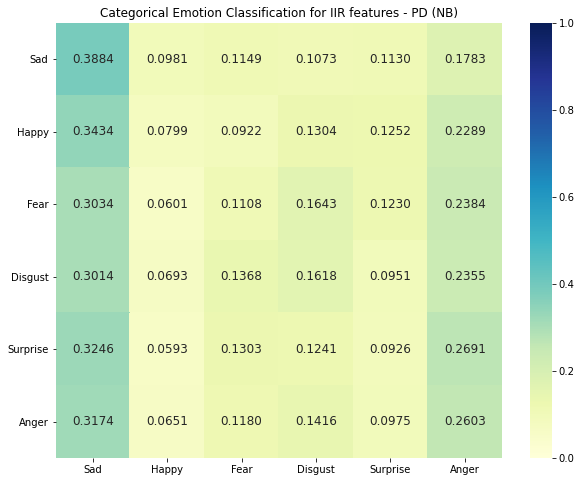

In [5]:
#Naive Bayes
scoring = {'accuracy' : make_scorer(accuracy_score), 'f1_score' : make_scorer(f1_score, average='weighted')}
param = {'var_smoothing': [0.0001,0.001,0.01,0.1,1,10,100,100,1000]}

opt = GridSearchCV(GaussianNB(), param_grid=param, cv=10, verbose=2, n_jobs=-1)
clf = opt.fit(X,y)
best_params = opt.best_params_
print('Best parameters:', best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = GaussianNB(var_smoothing=best_params.get('var_smoothing'))
'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring=scoring, verbose=2)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print('Accuracy:', round(np.mean(acc),4), '+-', round(np.std(acc),4)) 
print('F1Score:', round(np.mean(f1),4), '+-', round(np.std(f1),4))
'''
cm_list = []
acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
#conf_mat = np.zeros((2,2))
conf_mat = np.zeros((6,6))
for train_index, test_index in kfold.split(X, y): 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 
    estimator.fit(X_train, y_train) 
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)
    wtd_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    wtd_f1_list.append(wtd_f1)
    macro_f1_list.append(macro_f1)
    #cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5,6])
    cm = cm/cm.sum(axis=1, keepdims=True)
    #conf_mat = conf_mat+cm
    cm_list.append(cm)

#conf_mat /= conf_mat.sum(axis=1, keepdims=True) #Normalised values in the CM
conf_mat = np.mean(cm_list, axis=0)
acc_mean = round(np.mean(acc_list),3)
acc_std = round(np.std(acc_list),3)
wtd_f1_mean = round(np.mean(wtd_f1_list),3)
wtd_f1_std = round(np.std(wtd_f1_list),3)
macro_f1_mean = round(np.mean(macro_f1_list),3)
macro_f1_std = round(np.std(macro_f1_list),3)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
#ax.set_yticklabels(['LA','HA'],rotation = 0)
#ax.set_xticklabels(['LA','HA'],rotation = 0)
ax.set_yticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'],rotation = 0)
ax.set_xticklabels(['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename[:-4]+'_conf_mat'+'.png')
plt.show()

# Save results
sio.savemat(filename, {'conf_mat':conf_mat, 'conf_mat_list': cm_list, 'best_params':best_params,
                       'acc_list':acc_list, 'wtd_f1_list':wtd_f1_list, 'macro_f1_list':macro_f1_list})

# Logistic Regression

In [ ]:
#Logistic Regression

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_score': make_scorer(f1_score, average='weighted')}
#scoring = ['accuracy', 'f1_score']

param = {'penalty':['l2','none'],'C':[0.001,0.01,0.1,1,10,100,1000]}

opt = GridSearchCV(LogisticRegression(), param_grid=param, cv=10, verbose=2, n_jobs = -1)

logclf = opt.fit(X, y)
best_params = opt.best_params_
print('Best parameters:',best_params)

kfold = StratifiedKFold(n_splits=10)
estimator = LogisticRegression(C = best_params.get('C'), penalty=best_params.get('penalty'))

'''
crossval = cross_validate(estimator, X, y, cv=kfold, scoring = scoring, verbose=2, n_jobs = -1)
print(crossval)
acc = crossval.get('test_accuracy')
f1 = crossval.get('test_f1_score')
print("Accuracy:", round(np.mean(acc), 4), "+-", 
      round(np.std(crossval.get('test_accuracy')), 4))
print("F1 score:", round(np.mean(f1), 4), "+-",
      round(np.std(crossval.get('test_f1_score')), 4))
'''
acc_list = [] 
wtd_f1_list = []
macro_f1_list = []
conf_mat = np.zeros((2,2))
for train_index, test_index in kfold.split(X, y): 
  X_train, X_test = X[train_index], X[test_index] 
  y_train, y_test = y[train_index], y[test_index] 
  estimator.fit(X_train, y_train) 
  y_pred = estimator.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  acc_list.append(acc)
  wtd_f1 = f1_score(y_test, y_pred, average='weighted')
  macro_f1 = f1_score(y_test, y_pred, average='macro')
  wtd_f1_list.append(wtd_f1)
  macro_f1_list.append(macro_f1)
  cm = confusion_matrix(y_test, y_pred, labels=[0,1])
  conf_mat = conf_mat+cm

conf_mat /= conf_mat.sum(axis=1, keepdims=True)
acc_mean = round(np.mean(acc_list),4)
acc_std = round(np.std(acc_list),4)
wtd_f1_mean = round(np.mean(wtd_f1_list),4)
wtd_f1_std = round(np.std(wtd_f1_list),4)
macro_f1_mean = round(np.mean(macro_f1_list),4)
macro_f1_std = round(np.std(macro_f1_list),4)
print('Accuracy:',acc_mean,'+-',acc_std)
print('Weighted FScore:',wtd_f1_mean,'+-',wtd_f1_std)
print('Macro FScore:',macro_f1_mean,'+-',macro_f1_std)
#conf_mat = plot_confusion_matrix(estimator, X_test, y_test, cmap=plt.cm.Blues)   
#conf_mat.ax_.set_title('Conf_mat - Tree - HV vs LV - Full data')
#fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='.4f', vmin=0, 
                 vmax=1, annot_kws={"fontsize":12})
ax.set_yticklabels(['NC','PD'],rotation = 0)
ax.set_xticklabels(['NC','PD'],rotation = 0)
ax.set_title(cm_title)
ax.get_figure().savefig(filename)
plt.show()